In [57]:
# import packages
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as tree
from sklearn.ensemble import RandomForestClassifier as rforest
from sklearn.neural_network import MLPClassifier as nnet
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import metrics
from scipy import interp

In [42]:
# load and parse dataset
data = datasets.load_breast_cancer()
features = pd.DataFrame(data['data'], columns=data['feature_names'])
labels = data['target']

In [43]:
features.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [44]:
# pre-process features
scale = preprocessing.StandardScaler()
features_scaled = scale.fit_transform(features)

print("feature mean", np.mean(features_scaled, axis=0))
print("feature std", np.std(features_scaled, axis=0))

feature mean [ -3.16286735e-15  -6.53060890e-15  -7.07889127e-16  -8.79983452e-16
   6.13217737e-15  -1.12036918e-15  -4.42138027e-16   9.73249991e-16
  -1.97167024e-15  -1.45363120e-15  -9.07641468e-16  -8.85349205e-16
   1.77367396e-15  -8.29155139e-16  -7.54180940e-16  -3.92187747e-16
   7.91789988e-16  -2.73946068e-16  -3.10823423e-16  -3.36676596e-16
  -2.33322442e-15   1.76367415e-15  -1.19802625e-15   5.04966114e-16
  -5.21317026e-15  -2.17478837e-15   6.85645643e-16  -1.41265636e-16
  -2.28956670e-15   2.57517109e-15]
feature std [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [65]:
# fit a few different machine learning classifiers/parameter combinations
# using cross validation and accumulate results

names = ["linear_svc", "rbf_svc", "knn_six", "knn_three",
         "tree", "tree_max_depth_5", "random_forest",
         "random_forest_max_depth_5", "neural_net_relu",
         "neural_net_logistic"]
all_classifiers = [SVC(kernel="linear", probability=True),
                   SVC(kernel="rbf", probability=True),
                   knn(6),
                   knn(3),
                   tree(),
                   tree(max_depth=5),
                   rforest(),
                   rforest(max_depth=5),
                   nnet(activation="relu"),
                   nnet(activation="logistic")]

cv = StratifiedKFold(n_splits=5, random_state=12345)

fpr_sampling = np.linspace(0, 1, 100)

all_classifier_results = []
for name, clf in zip(names, all_classifiers):
    # cross-validation
    auc_accum = []
    fpr_accum = []
    tpr_accum = []
    for train, test in cv.split(features_scaled, labels):

        X_train, X_test = features_scaled[train, :], features_scaled[test, :]
        y_train, y_test = labels[train], labels[test]

        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        y_pred = y_prob[:, 1]

        fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
        tpr_interp = interp(fpr_sampling, fpr, tpr)
        tpr_interp[0] = 0.
        # accumulate
        tpr_accum.append(tpr_interp)
        auc_accum.append(metrics.auc(fpr, tpr))
    
    # compute mean tpr, fpr, auc
    out = (name, np.mean(tpr_accum, axis=0), np.mean(auc_accum),
           np.std(tpr_accum, axis=0), np.std(auc_accum))
    all_classifier_results.append(out)

C:\Users\garlex\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


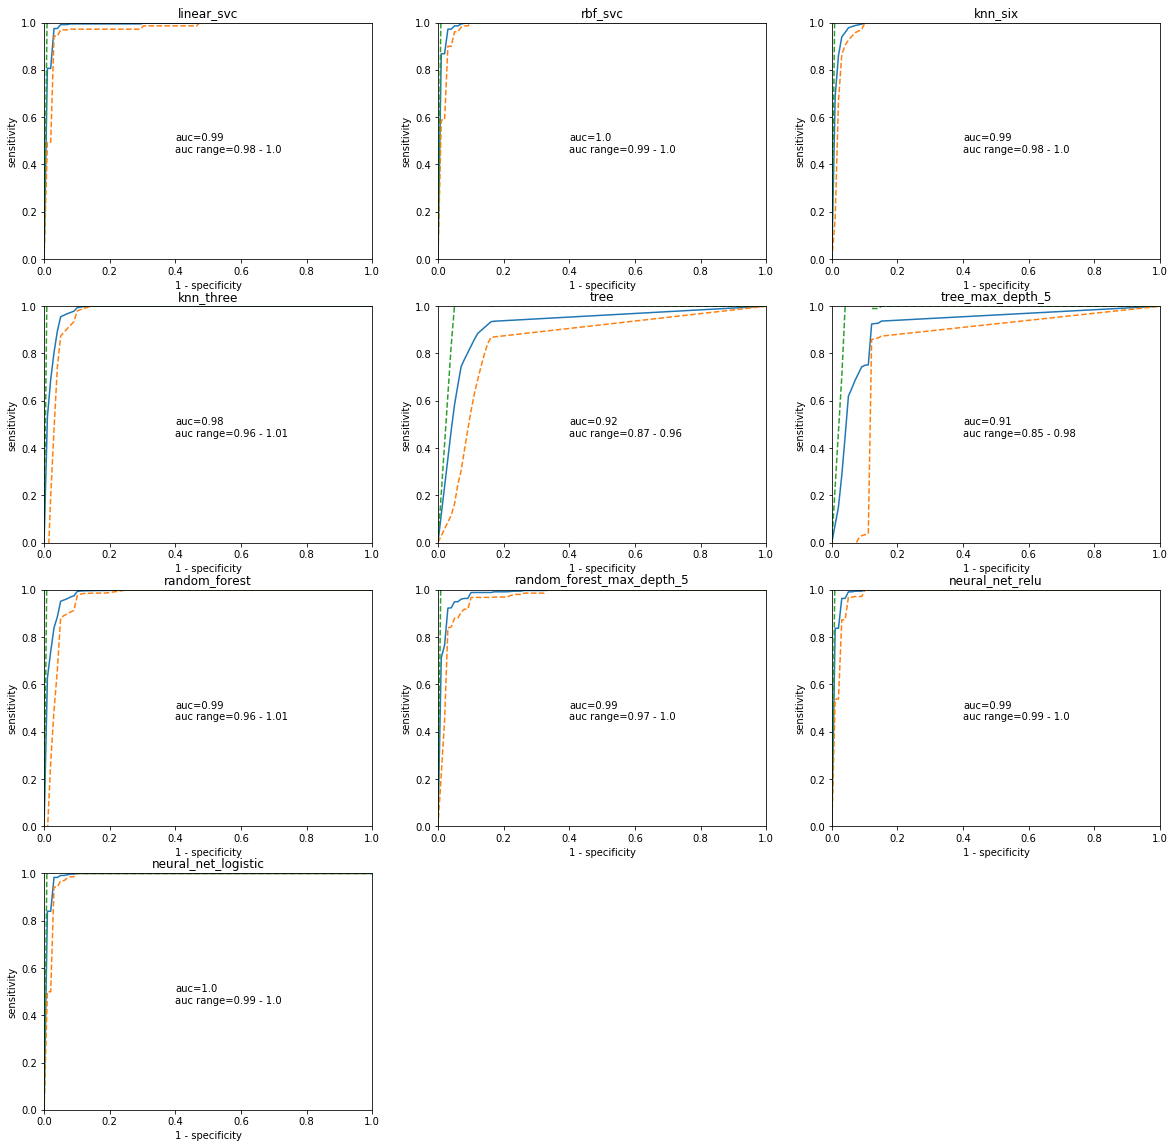

In [97]:
# plot resulting ROC curves
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 20))

for i, res in enumerate(all_classifier_results):
    title, tpr, auc, tpr_std, auc_std = res
    plt.subplot(4, 3, i+1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot(fpr_sampling, tpr, '-')
    plt.plot(fpr_sampling, tpr - 2 * tpr_std, '--')
    plt.plot(fpr_sampling, tpr + 2 * tpr_std, '--')
    plt.title(title)
    plt.ylabel('sensitivity')
    plt.xlabel('1 - specificity')
    plt.text(0.4, 0.5, 'auc=' + str(np.around(auc, 2)))
    plt.text(0.4, 0.45, 'auc range=' + str(np.around(auc - 2 * auc_std, 2)) + " - " + str(np.around(auc + 2 * auc_std, 2)))